<div class="alert alert-info">
<style>
    
</style>
*подключить Nbextensions toc2/main для формирования TOC не вышло, поэтому оглавление ниже было создано вручную с помощью Markdown и HTML, понимаю, что подход не лучший, но по крайней мере рабочий*</div>

## TOC:
* **[Постановка задачи](#1)**  
    * [Ход работы](#1.1)

* **[Исследование](#2)**  
    * [Загрузка, импорты, EDA](#2.1)  
    * [Преобработка данных, отбор признаков](#2.2)
    
* **[Обучение моделей](#3)**  

* **[Вывод](#4)**  

# <center>4.1. Машинное обучение на больших данных.</center>

<p style="text-align:right;">выполнил студент: Морозов Е.А.</p>

***


## 1. Постановка задачи. <a class="anchor" id="1"></a>

Машинное обучение является одним из самых перспективных направлений в IT. В данной практической работе рассматривались основы машинного обучения: классы задач машинного обучения, линейные модели, методы борьбы с переобучением моделей и некоторые способы улучшения качества моделей. В рамках самостоятельной раборы требоуется обучить несколько моделей машинного обучения в Python и выполнить ряд задач по отбору признаков, разделению выборки, подбору гиперпараметров и расчёту метрик.  

Источник данных (kaggle titanic dataset): https://www.kaggle.com/competitions/titanic/data?select=train.csv


### 1.1. Ход работы.  <a class="anchor" id="1.1"></a>

1. Загрузите данные.

2. Исключите признаки, которые на ваш взгляд, могут привести к переобучению (например, id).

3. Разделите выборку на train и test.

4. Преобразуйте категориальные признаки с помощью sklearn.preprocessing.OneHotEncoder, а некатегориальные с помощью sklearn.preprocessing.StandardScaler

5. Обучите модели логистической регрессии и KNN, посчитайте все метрики классификации, которые были упомянуты на занятии, сделайте выводы.

6. Подберите гиперпараметры для обоих моделей с помощью RandomizedSearchCV, напишите, почему, как вы думаете, эти параметры подошли.

7. Посчитайте метрики для новых моделей, также сделайте выводы.  

***


## 2. Исследование. <a class="anchor" id="2"></a>

Загрузим и проанализируем данные.  

Датасет на странице соревнования представлен в разделённом на тренировочную и тестовую выборки виде, использовалась лишь тренировочная выборка. Данные представлены в табличном виде, описание содержащихся признаков ниже:  

***Описание данных:***

Variable | Definition | Key | Notes
:------ | :------: | :------ | :------
***survival*** | Survival | 0 = No, 1 = Yes|
***pclass*** | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd | 1st = Upper, 2nd = Middle, 3rd = Lower 
***sex*** | Sex | 
***Age*** |	Age in years | | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 
***sibsp***	| # of siblings / spouses aboard the Titanic | | The dataset defines family relations in this way:  ***Sibling*** *= brother, sister, stepbrother, stepsister.*  ***Spouse*** *= husband, wife (mistresses and fiancés were ignored)*  
***parch***	| # of parents / children aboard the Titanic | | The dataset defines family relations in this way:  ***Parent*** *= mother, father.*  ***Child*** *= daughter, son, stepdaughter, stepson. Some children travelled only with a nanny, therefore parch=0 for them.*
***ticket*** |	Ticket number	| 
***fare***	| Passenger fare	| 
***cabin***	| Cabin number	| 
***embarked***	| Port of Embarkation |	C = Cherbourg, Q = Queenstown, S = Southampton


### 2.1. Загрузка, импорты, EDA. <a class="anchor" id="2.1"></a>  

Сделаем импорты, установим компоненты для работы. 

In [431]:
# импортируем библиотеки:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
np.set_printoptions(precision=4)
from random import sample

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score,\
                            precision_recall_curve, accuracy_score, auc, classification_report, \
                            confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

# отключим предупреждения:
import warnings
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None # чтобы избавиться от конфликта pandas и sklearn

# зададим состояние генератора случайных чисел для исползуемых объектов:
state = np.random.RandomState(606)
#np.random.seed(606) - не работал как хотелось, не понял почему

Прочитаем файлы (обединим их при возможности) и проведём разведочный анализ данных.

Датасет на странице соревнования представлен в разделённом на тренировочную и тестовую выборки виде, сперва хотелось объединить датасеты в одиин (для "обогащения", а после, в ходе работы, делилить на учебную и тестовую части), но оказалось, что тестовый вариант не размечен, поэтому использовалась лишь тренировочная выборка.

In [432]:
# загрузим/объединим датафреймы
#df = pd.concat([pd.read_csv('./train.csv'), pd.read_csv('./test.csv')], ignore_index=True)
df = pd.read_csv('./train.csv')

# вывод информации о хранящихся значениях
print(f'\nСодержимое csv-файлов проекта (2 объединённых сsv-таблицы).')
print()
print(f'\t\033[1mПолученный датафрейм\033[0;0m:')
print(f'\t- размеры (строк, столбцов):', df.shape)
print(f'\t- фрагмент (см. ниже):')
display(df.tail(10))
print(f'\n\t - пропущенных значений (по столбцам)')
print(df.isna().mean())
print(f'\n\t- типы данных (по столбцам)')
print(df.dtypes)

print(f'\n\nПодробнее об уникальных значениях столбцов полученной таблицы.')
print(f'\nвсего уникальных значений в столбце:')
for col in df.columns:
    print(f'. \033[1m{col}\033[0;0m - {len(df[col].unique())} шт.')
    print(f'  список уникальных значений (первая сотня):\n {df[col].sort_values().unique()[:100]}\n')


Содержимое csv-файлов проекта (2 объединённых сsv-таблицы).

	Полученный датафрейм:
	- размеры (строк, столбцов): (891, 12)
	- фрагмент (см. ниже):


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q



	 - пропущенных значений (по столбцам)
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

	- типы данных (по столбцам)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Подробнее об уникальных значениях столбцов полученной таблицы.

всего уникальных значений в столбце:
. PassengerId - 891 шт.
  список уникальных значений (первая сотня):
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  

Выводы:  
- датасет небольшой, объеты предоставлены достаточно широким набором признаков, однако не все из них можно считать полезными при обучении моделей.  
- существенная часть строк имеет пропуски в данных в одном из столбцов из числа: "Age", "Cabin", "Embarked"  - в зависимости от выбранных для обучения моделей признаков это может сильно ухудшить результаты из-за снижения объёма выборки, поскольку модели не обучаются на пропусках. Лучшим решением видится заполнение отсутствующих значений средним или медианным значением либо модой (в случае категориального признака).  
- данные представлены не только в числовом формате, но и в виде строковых значений типа object, в таких столбцах содержатся категориальные признаки, не всегда рангового вида, в данных случаях в качестве предобработки потребуется проводить кодирование значений для преобразования их в числовые величины.  
- преобразования важно проводить после разделения выборки на обучающую и тестовую части во избежание утечек, при этом нормировать/кодировать значения тестовой выборки необходимо по полученным на обучающей выборке характерным значениям.  


### 2.2. Предобработка данных, отбор признаков. <a class="anchor" id="2.2"></a>  

Проведём предобработку данных, отборём признаки для последующего обучения моделей, заполненим пропуски. Выполним разбиение датасета и преобразования перед обучением моделей.



In [433]:
df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
361,362,0,2,"del Carlo, Mr. Sebastiano",male,29.0,1,0,SC/PARIS 2167,27.7208,NaN,C
379,380,0,3,"Gustafsson, Mr. Karl Gideon",male,19.0,0,0,347069,7.7750,NaN,S
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,NaN,S


- Столбец "Survived" - целевой признак по определению
- Столбцы "PassengerId", "Name", "Ticket", "Cabin" и "Embarked" содержат либо слишком много значений, либо пропусков либо не несут существенной информации (поскольку корабль затонул независимо от порта назначения) - указанные столбцы проще будет выбросить из рассмотрения. 
- Оставшиеся столбцы можно считать подходящими для исользования в качестве признаков, но над ними нужно будет провести преобразования и заполнить пропуски.  
- Хороший прирост точности могут дать синтетические признаки, сформируем один столбец с таким признаком на основании данных имеющихся признаков.  


Прежде же перечисленных выше действий оценим распределения значений и баланс классов признаков поскольку это сказывается на метриках качества моделей. При несбалансированной классификации желательно учитывать дисбаланс как при выборе метрики качества, так и в гиперпараметрах моделей, так и при разделении выборки (в виде стратификации по наиболее несбалансированным классам).

In [434]:
# сразу отбросим признаки, принятые за незначимые
df = df.drop(columns=[df.columns[0],df.columns[3],df.columns[8],df.columns[10],df.columns[11]])

В ***данной работе*** заполним пропуски и кодируем значения до разделения выборки на обучающую и тестовую.  

Появится некоторая утечка данных, поскольку пропуски будут заполняться по характерным знаениям, вычисленным для всего диапазона и они будут несколько отличаться от тех, какими они были бы, если бы значения вычислялись на тренировочной выборке и подставлялись бы на место пропусков в тестовой, но в данном случае, дабы не перегружать исследование, этим можно пренебречь.

In [435]:
# заполним пропуски по среднему значению, взятому из соотв. группировки
df['mean_age'] = df.groupby(by=['Sex','Pclass','Parch'])['Age'].transform('mean')
df['Age'].fillna(df['mean_age'], inplace=True)

# добавим синтетические признаки
df['synt'] = np.round(df.apply(lambda x: (x[6]/x[3])*(x[1]+x[4]+x[5]), axis=1),3)
df['synt_fam'] = np.round((df['SibSp'] + df['Parch'])**0.5, 3)
df.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,mean_age,synt,synt_fam
789,0,1,male,46.000000,0,0,79.2000,42.506410,1.722,0.000
420,0,3,male,28.816667,0,0,7.8958,28.816667,0.822,0.000
754,1,2,female,48.000000,1,2,65.0000,20.454545,6.771,1.732
90,0,3,male,29.000000,0,0,8.0500,28.816667,0.833,0.000
295,0,1,male,42.506410,0,0,27.7208,42.506410,0.652,0.000


Часть значений хотя и выражена числами, но является дискретной величиной и соотв. имеет смысл категориального признака, для таких величин статистическое описание или корреляции с непрерывными величинами счиать неверно.

Матрица корреляций:
          Survived       Age      Fare    Pclass      synt
Survived  1.000000 -0.065051  0.257307 -0.338481  0.060022
Age      -0.065051  1.000000  0.104954 -0.403946 -0.356432
Fare      0.257307  0.104954  1.000000 -0.549500  0.192786
Pclass   -0.338481 -0.403946 -0.549500  1.000000 -0.013817
synt      0.060022 -0.356432  0.192786 -0.013817  1.000000

          Survived     SibSp     Parch  synt_fam
Survived  1.000000 -0.035322  0.081629  0.116264
SibSp    -0.035322  1.000000  0.414838  0.794611
Parch     0.081629  0.414838  1.000000  0.769025
synt_fam  0.116264  0.794611  0.769025  1.000000

Статистические параметры:
              Age        Fare        synt
count  891.000000  891.000000  891.000000
mean    29.489624   32.204208    9.213377
std     13.428578   49.693429   36.317253
min      0.420000    0.000000    0.000000
25%     21.500000    7.910400    0.808500
50%     28.816667   14.454200    1.285000
75%     36.285714   31.000000    3.854000
max     80.000000

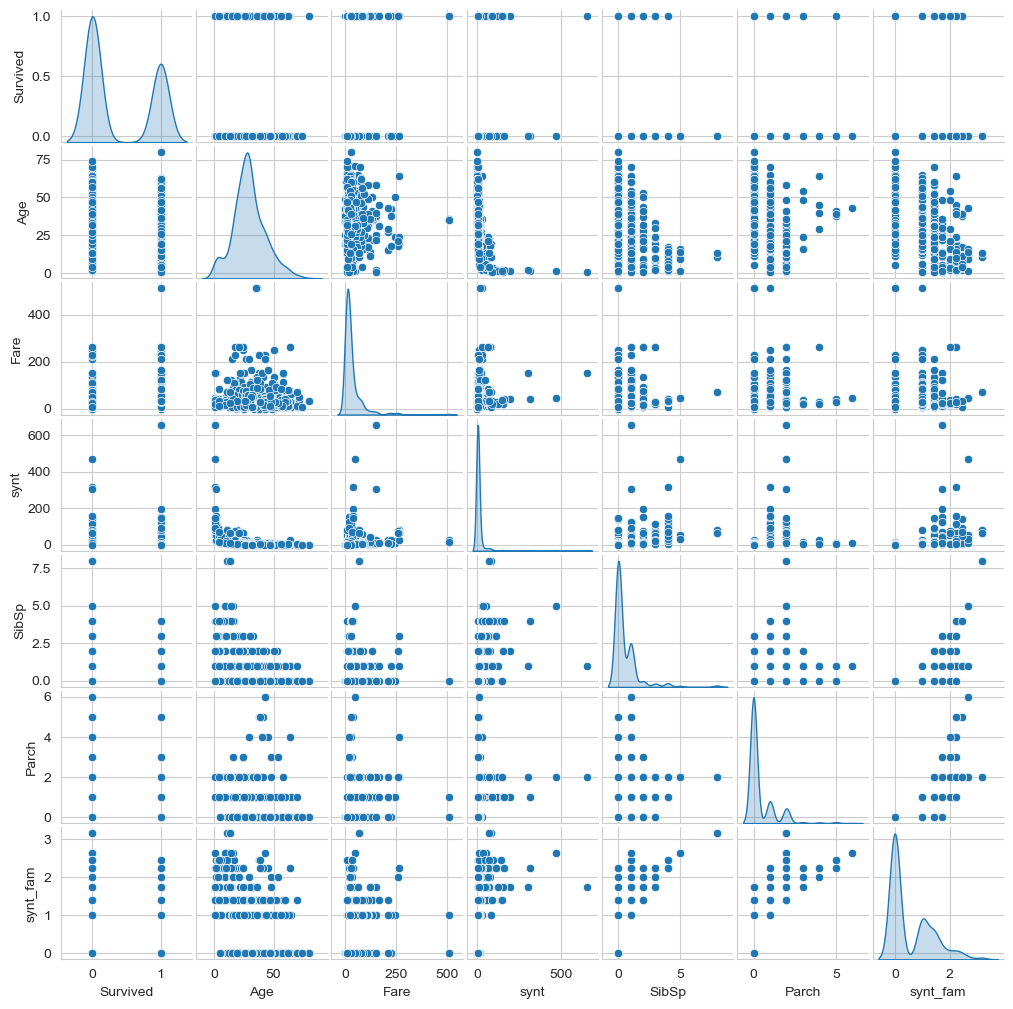

In [436]:
# выведем корелляцию и стат.описания для числовых признаков
print('Матрица корреляций:')
print(df[['Survived','Age','Fare','Pclass','synt']].corr())
print()
print(df[['Survived','SibSp','Parch','synt_fam']].corr())
print()

print('Статистические параметры:')
print(df[['Age','Fare','synt']].describe())
print()

# выведем матрицу диаграмм рассеяния для столбов таблицы df
print('Матрица диаграмм рассеяния таблицы "df"')
sns.pairplot(df[['Survived','Age','Fare','synt','SibSp','Parch', 'synt_fam']], diag_kind='kde').fig.set_size_inches(10,10)
plt.show()

Изначально данное небольшое количество числовых признаков (2 столбца) даёт небольшое количество информации для обучения модели, поэтому было решено добавить синтетичекий числовой признак "synt".  

Cинтетичекий числовой признак "synt_fam" было добавлен, чтобы учесть в одном признаке значения 2 колонок "SibSp" и "Parch", которые имеют явный дисбаланс классов, и который таким образом превратится в неитерпритируемую, но непрерывную числовую величину и позволит его не учитывать среди категориальных признаков.  

Можно видеть, что распределения далеки от нормальных и скошены влево, т.к. количество малых величин превалирует над остальными, но есть и другие пики. Корреляция между значениями слабые, скорее всего эти величины связаны не столько между собой и линейно сколько с иными показателями и нелинейно. Для обучения моделей количественные признаки представляют интерес.  

Далее оценим балансы классов столбцов с категориальными значениями. Кодирование переменных будут выполнены следом за этим этапом для получения числовых значений в соотв. столбце.


Баланс классов категориальных признаков c круговыми диаграммами.

	- столбец Survived


,Survived
0,61.6%
1,38.4%


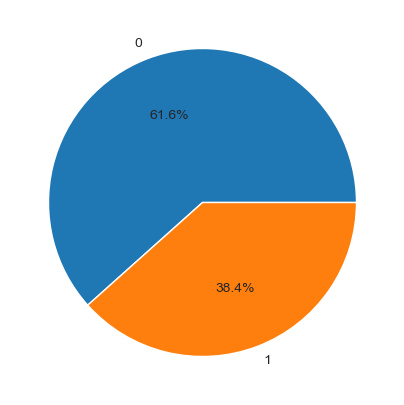

	- столбец Pclass


,Pclass
3,55.1%
1,24.2%
2,20.7%


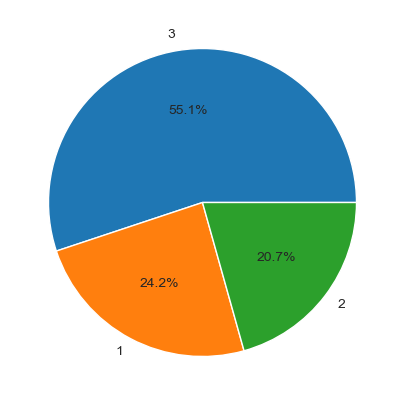

	- столбец Sex


,Sex
male,64.8%
female,35.2%


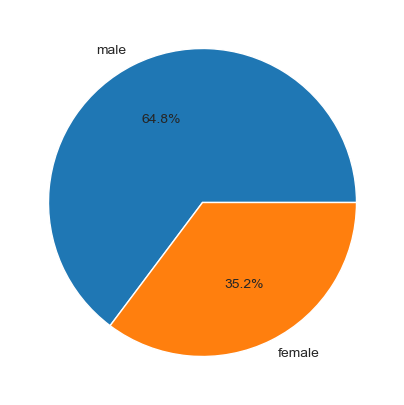

In [437]:
# рассмотрим балансы классов категориальных и дискретных числовых признаков
print(f'\nБаланс классов категориальных признаков c круговыми диаграммами.\n')
df.drop(columns=['SibSp','Parch','mean_age'], inplace=True)

for col in df.columns:
    if (df[col].dtype != 'float64'):
        print(f'\t- столбец {col}')
        _t = pd.DataFrame(df[col].value_counts(normalize=True, ascending=False))
        display(_t.style.format('{:.1%}'))

        plt.figure(figsize=(5,5))
        plt.pie(_t[col],labels=_t.index,autopct='%1.1f%%')
        plt.show()

Классы признаков плохо сбалансированы, будем учитывать это в стратификации выборок (а также возможно при выборе весов категориальных признаков в гиперпарметрах моделей).  

Перекодируем значения столбца "Sex" с помощью энкодера **sklearn** для тренировки и чтобы получить из значений столбца числовые величины, с которыми смогут работать модели из задания.

In [438]:
# кодируем категориальный признак, отбрасываем первую колонку во избежание коллинеарности
df['is_male'] = (
    OneHotEncoder(handle_unknown='ignore', drop='if_binary')
    .fit(df['Sex']
         .values.reshape(-1,1))
    .transform((df['Sex'])
               .values.reshape(-1,1))
    .toarray()
    .astype('int')
)

# удаляем исходный столбец, значения которого кодировались
df.drop(columns=['Sex'], inplace=True)
df.sample(3)

,Survived,Pclass,Age,Fare,synt,synt_fam,is_male
678,0,3,43.00,46.9000,10.907,2.646,0
469,1,3,0.75,19.2583,154.066,1.732,0
682,0,3,20.00,9.2250,1.384,0.000,1


### 2.3. Разделение выборки, масштабирование признаков. <a class="anchor" id="2.3"></a>  

Все признаки приняли вид числовых значений, но они ещё не смасштабированы, проделаем эту операцию далее. Как минимум линейные и кластерные модели могут быть чувствительны к различным масштабам признаков. Разделим выборку на обучающую и тестовую части, произведём нормирование.  

In [439]:
# разделим датафрейм на целевой признак и признаки:
features = df.drop(columns=['Survived'])
target = df['Survived']

# разделим выборки на тренировочную и тестовую в отношении 3:1:
features_train, features_test, target_train, target_test = (
    train_test_split(features, target, test_size=0.25,
                     random_state=state,
                     stratify=df[['is_male','Pclass','Survived']])
)

print('Сопоставим размеры выборок.')
print('признаки: обучающая -',features_train.shape, 'тестовая -',features_test.shape)
print('целевой признак: обучающая -',target_train.shape, 'тестовая -',target_test.shape)

print(f'''\nДля проверки работы гиперпараметра "stratify" сопоставим стратификацию классов в полученных выборках.

- обучающая выборка
{features_train[['is_male','Pclass']].value_counts(normalize=True).round(4)}

- тестовая выборка
{features_test[['is_male','Pclass']].value_counts(normalize=True).round(4)}

Баланс классов в целевом признаке:

- обучающая выборка
{target_train.value_counts(normalize=True).round(4)}

- тестовая выборка
{target_test.value_counts(normalize=True).round(4)}''')

Сопоставим размеры выборок.
признаки: обучающая - (668, 6) тестовая - (223, 6)
целевой признак: обучающая - (668,) тестовая - (223,)

Для проверки работы гиперпараметра "stratify" сопоставим стратификацию классов в полученных выборках.

- обучающая выборка
is_male  Pclass
1        3         0.3892
0        3         0.1617
1        1         0.1377
         2         0.1213
0        1         0.1048
         2         0.0853
dtype: float64

- тестовая выборка
is_male  Pclass
1        3         0.3901
0        3         0.1614
1        1         0.1345
         2         0.1211
0        1         0.1076
         2         0.0852
dtype: float64

Баланс классов в целевом признаке:

- обучающая выборка
0    0.6168
1    0.3832
Name: Survived, dtype: float64

- тестовая выборка
0    0.6143
1    0.3857
Name: Survived, dtype: float64


В меру имеющегося разнообразия, но выборки всё-таки получились довольно стратифицированными. Смасштабируем значения.

In [440]:
# разделим признаки по категориям
cat_features = features.select_dtypes(include='object').columns.values     # категориальные
num_features = features.select_dtypes(include=['float64','int64']).columns.values    # числовые (только с плав.точкой, целые не масштабируем)
bool_features = features.select_dtypes(include='bool').columns.values      # булевы (на всякий случай)

# преобразуем признаки перед передачей в Pipeline c модель. с пом. ColumnTransformer
prepr = (
    ColumnTransformer([
        ('cat_no_bool',
         OneHotEncoder(drop='if_binary', handle_unknown='ignore'),
         cat_features)
        , ('num_no_bool',
           StandardScaler(),
           num_features)
        , ('bool',
           OneHotEncoder(drop='if_binary', handle_unknown='error'),
           bool_features)
    ])
)

Не все преобразования необходимы в данной работе (часть из них уже была выполнена с той или иной степенью тщательности), но конвейер обработки признаков захотелось сделать более или менее универсальным, почему он и получил расширенный функционал, который просто не будет применяться, если колонка с признаком не подходит под указанные условия.  

Полученный конвейер обработки признаков `ColumnsTransformer()` будем передавать в конвейер `Pipeline()`, содержащий рассматриваемую ML-модель, а его в третью очередь - на кросс-валидацию и поиск гипер-параметров (далее - ГП) в `RandomizedSearchCV()`.  

***

## 3. Обучение моделей.  <a class="anchor" id="3"></a>  

Перед началом исследования определимся с применяемыми ML-алгоритмами и метриками оценки эффективности моделей.  

Для обучения будем пользоваться:
- ***логистической регрессией***,  
- ***алгоритмом К-ближайших соседей***,
- В качесиве базовой оценки примем результаты работы `DummyClassifier` (из библиотеки `sklearn`).  

В задаче классификации оперировать только метрикой **accuracy** будет недостаточно, нужно учитывать также изменения **precision** и **recall**. С этим вполне справится **F1-мера**, но поскольку она отражает среднее гармоническое оценок для конкретно выбранного порога чувствительности, то диапазон возможных изменений (для всех порогов) удобнее оценивать по **ROC-AUC**.  


### 3.1. Константная модель.  

Получим оценку константной/случайной модели по результатам работы `DummyClassifier`, примем её за базовую. Последовательно передадим `DummyClassifier` гиперпараметры `strategy='uniform'` и `strategy='constant'`, чтобы получить случайную модель и константную, которая отвечает "1" независимо от значений на входе.  

In [441]:
%%time

# создадим словарь для хранения значений ROC-AUC мер
roc_auc_scores = {}

dummy_random = DummyClassifier(random_state=state, strategy='uniform')
dummy_const = DummyClassifier(random_state=state, strategy='constant', constant=1)

model = [dummy_random, dummy_const]
name = ['CЛУЧАЙНАЯ','КОНСТАНТНАЯ']

# цикл по 2 моделям
for i in range(len(model)):
    clf = Pipeline([           # Pipeline с предобработкой и моделью
        ('prepr', prepr),
        ('estimator', model[i])
    ])
    
    # получение оценок моделей
    print(f'модель - {str(model[i])[:16]}...{str(model[i])[-20:-1]})')
    print(f'ROC-AUC мера модели ({name[i]}):',
          cross_val_score(clf, features_train, target_train, 
                          scoring='roc_auc', cv=5).mean(), '\n') # ROC-AUC после кросс-валидации
    
    # добавим результаты в словарь
    roc_auc_scores[f'{name[i]} модель'] = (
        cross_val_score(clf
                        , features_train, target_train
                        , scoring='roc_auc', cv=5)
        .mean()
        .round(4)
    )

модель - DummyClassifier(... strategy='uniform')
ROC-AUC мера модели (CЛУЧАЙНАЯ): 0.5 

модель - DummyClassifier(...strategy='constant')
ROC-AUC мера модели (КОНСТАНТНАЯ): 0.5 

Wall time: 156 ms


### 3.2. Логистическая регрессия.  

Получив base-line решение, сравним его с результатом модели, обученной на ***логистической регрессии***.  

Лучшие гиперараметры найдём поиском по сетке с кросс-валидацией (с пом. `RandomizedSearchCV`): для устранения переобучения предполагается в основном варьировать параметром *C: Inverse of regularization strength*, чтобы достаточно понизить оценки на обучающей выборке. Подбирать значение лучшего порога (поскольку непосредственно в модели логистической регрессии из `sklearn` такого функционала нет) не станем.  

In [442]:
%%time

model = LogisticRegression(random_state=state)

# Pipeline с предобработкой и моделью
clf = Pipeline([
    ('prepr', prepr),
    ('estimator', model)
])

# поиск лучших гиперпарметров по сетке с кросс-валидацией
grid = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': [0.01, 0.1, 0.2, 0.3, 0.5, 1, 10, 100, 1000],
    'estimator__max_iter': range(10,1000,1),
    'estimator__class_weight': ['balanced', 'None'],
    'estimator__solver': ['saga', 'liblinear', 'lbfgs']
}

LR_clf = RandomizedSearchCV(
    clf,
    param_distributions=grid,
    n_iter=10000,
    scoring='roc_auc',
    cv=5, verbose=1, n_jobs=-1
)

LR_clf.fit(features_train, target_train)

# выведем результаты на экран:
print('\nЛогистическая регрессия\n')
print('- Лучший ROC-AUC = ', LR_clf.best_score_.round(5))
print('- Лучшие параметры:\n\t', {str(i)[11:]:LR_clf.best_params_.get(i) for i in LR_clf.best_params_})
print('- Лучшая модель:\n\t доступна из "LR_clf.best_estimator_"\n')

# добавим результаты в словарь
roc_auc_scores[f'Логистическоая регрессия'] = LR_clf.best_score_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits

Логистическая регрессия

- Лучший ROC-AUC =  0.74205
- Лучшие параметры:
	 {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 618, 'class_weight': 'balanced', 'C': 0.2}
- Лучшая модель:
	 доступна из "LR_clf.best_estimator_"

Wall time: 1min 48s


Модель, построенная на основе алгоритма логистической регрессии, дала ощутимый прирост качества относительно случайного и константного классификаторов. Для настройки гиперпараметров модели использование **RandomizedSearchCV** вместо перебора всех вариантов по сетке **GridSearchCV** даёт заметный выигрыш в скорости выполнения и в теории (теории вероятности) близкие по качеству результаты.  


### 3.2. Классификация алгоритмом K-ближайших соседей.  

Повторим обучение модели с помощью алгоритма Взвешенных K-ближайших соседей.

In [443]:
%%time

model = KNeighborsClassifier()

# Pipeline с предобработкой и моделью
clf = Pipeline([
    ('prepr', prepr),
    ('estimator', model)
])

# поиск лучших гиперпарметров по сетке с кросс-валидацией
grid = {
    'estimator__n_neighbors': range(5,20,1),
    'estimator__weights': ['uniform', 'distance', lambda x: 1/(x+1)],
    'estimator__algorithm': ['auto'],
    'estimator__leaf_size': range(10,51,1),
    'estimator__p': [1,2]
}

KNС_clf = RandomizedSearchCV(
    clf,
    param_distributions=grid,
    n_iter=10000,
    scoring='roc_auc',
    cv=5, verbose=1, n_jobs=-1
)

KNС_clf.fit(features_train, target_train)

# выведем результаты на экран:
print('\nK-ближайших соседей\n')
print('- Лучший ROC-AUC = ', KNС_clf.best_score_.round(5))
print('- Лучшие параметры:\n\t', {str(i)[11:]:KNС_clf.best_params_.get(i) for i in KNС_clf.best_params_})
print('- Лучшая модель:\n\t доступна из "KNС_clf.best_estimator_"\n')

# добавим результаты в словарь
roc_auc_scores[f'Взвешенный K-ближайших соседей'] = KNС_clf.best_score_

Fitting 5 folds for each of 3690 candidates, totalling 18450 fits

K-ближайших соседей

- Лучший ROC-AUC =  0.78885
- Лучшие параметры:
	 {'weights': <function <lambda> at 0x0000025B43F11040>, 'p': 1, 'n_neighbors': 19, 'leaf_size': 17, 'algorithm': 'auto'}
- Лучшая модель:
	 доступна из "KNС_clf.best_estimator_"

Wall time: 40.3 s


Результат ещё раз улучшился, используем его как итоговый. Довольно неожиданно, я предполагал, что в данной задаче превосходство будет за логистической регрессией, однако классификация на основе взвешенных оценок ближайших соседей вкупе с обучением в кросс-валидации показали результаты лучше. Намеренное ограничение кол-ва рассматриваемых алгоритмом соседей и размеров листьев алгоритма позволили снизили оценку, но скорее всего и снизили переобученность модели. 

***

## 4. Результаты на тестовой выборке, выводы.  <a class="anchor" id="4"></a>  

Переобучение возможно, но в силу как умышелнного ограничения диапазонов поиска ГП моделей, кросс-валиадации и поиска ГП по случайной сетке оно должно было уменьшиться. Однако сравним оценки моделей на отложенной тестовой выборке и составим выводы с использованием матрицы ошибок/отчётов о классификации и значимости признаков.  

In [444]:
# соберём результаты в общий датафрейм

# ROC-AUC построенных моделей
print('ROC-AUC построенных моделей:')
roc_auc_df = (
    pd.DataFrame.from_dict(roc_auc_scores,
                           orient='index',
                           columns=['ROC-AUC_train+cv'])
    .sort_values(by='ROC-AUC_train+cv', ascending=True)
    .round(4)
)

# соберём ROC-AUC моделей на тестовой выборке и добавим его столбцом в датафрейм roc_auc_df
dummy = (
    Pipeline([
        ('prepr', prepr),
        ('estimator', DummyClassifier(random_state=state, strategy='uniform'))
    ])
    .fit(features_train, target_train)
)

roc_auc_test = (
    [roc_auc_score(target_test, dummy.predict(features_test))                      #ROC-AUC случайной модели
     , 0.5                                                                         #ROC-AUC константной модели
     , roc_auc_score(target_test, LR_clf.best_estimator_.predict(features_test))   #ROC-AUC логистич.регрессии
     , roc_auc_score(target_test, KNС_clf.best_estimator_.predict(features_test))] #ROC-AUC К-ближайшиъ
)

roc_auc_df['ROC-AUC_test'] =  pd.Series(roc_auc_test, index=roc_auc_df.index)
roc_auc_df

ROC-AUC построенных моделей:


,ROC-AUC_train+cv,ROC-AUC_test
CЛУЧАЙНАЯ модель,0.5000,0.595782
КОНСТАНТНАЯ модель,0.5000,0.500000
Логистическоая регрессия,0.7420,0.652012
Взвешенный K-ближайших соседей,0.7888,0.665252


Оценки на тестовой выборке снилизись, что естественно, но лучшим по-прежнему остаётся результат алгоритма "Взвешенный K-ближайших соседей". В данной работе улучшать результаты не требуется, просто дополнительно взглянем на значимость признаков полученной модели и проанализируем матрицу ошибок классификации на тестовой выборке.  

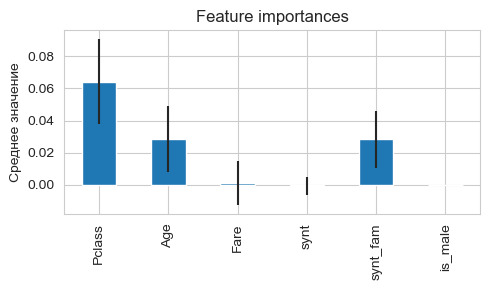

In [445]:
# построим график значимости признаков на основе permutation_importance
features_names = features_test.columns #названия столбцов

# получение словаря с permutation_importance
result = (
    permutation_importance(
        KNС_clf.best_estimator_
        , features_test, target_test
        , n_repeats=100
        , random_state=state)
)

# преобразуем в pd.Series для построения гистограммы
model_importances = pd.Series(result['importances_mean'], index=features_names)

# построение гистограммы значений со станд. отклонением
fig, ax = plt.subplots(figsize=(5,3))
model_importances.plot.bar(yerr=result['importances_std'], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Среднее значение")
fig.tight_layout()
plt.show()

**Вывод**:
- из интересного можно отметить, что синтетические признаки показывают значимость для моделей, особенно нелинейные.
- В то время как выбранные в качестве полезных признаки "Fare" и "is_male" таковую для моделей приобретают далеко не всегда. В ходе работы было решено нормировать их значения, как и другие числовые признаки, что придало определённый положительный эффект этим признакам, но изменило картину в целом, общее качество при этом подросло.  
- Оценка качества моделей в принципе не слишком высока и объём выборки невелик, поэтому выдающихся результатов достигнуто не было, значимость признаков неравномерна и не слишком велика.  

Ниже взглянем на матрицу ошибок лучшей модели.

Матрица мер классов целевого признака (на тестовой выборке):

              precision    recall  f1-score   support

     class 0       0.73      0.80      0.76       137
     class 1       0.62      0.53      0.57        86

    accuracy                           0.70       223
   macro avg       0.68      0.67      0.67       223
weighted avg       0.69      0.70      0.69       223


Матрица ошибок (на тестовой выборке):


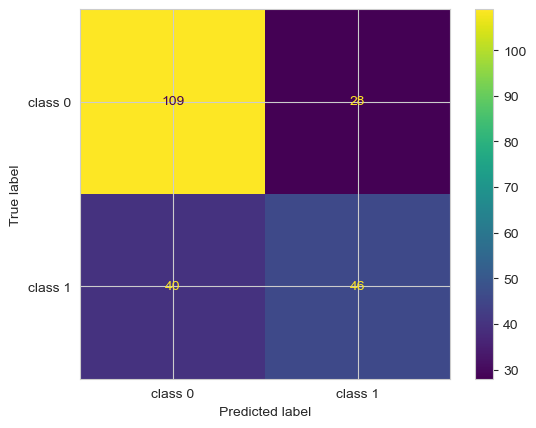

In [446]:
# classification_report
y_true = target_test
y_pred = KNС_clf.best_estimator_.predict(features_test)
target_names = ['class 0', 'class 1']
print('Матрица мер классов целевого признака (на тестовой выборке):\n')
print(classification_report(y_true, y_pred, target_names=target_names))
#print(confusion_matrix(y_true, y_pred))

# матрица ошибок
print('\nМатрица ошибок (на тестовой выборке):')
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=target_names).plot()
plt.show()

**Вывод**:
- Дисбаланс классов влияет на результаты предсказаний модели,  
- поскольку выборка была стратифицирована по целевому признаку, то и дисбаланс в равной мере переместился в тестовые данные.  
- Зная о преимущественном характере ложных срабатываний модели, можно корректировать её поведение, в качестве ориентира выбрав не F1, а иную F-меру в зависимости от значимости ложных значений для класссификации, либо иначе взвешивая классы при обучении.

В представленной модели результаты не видятся слишком удачными: на тесте модель среди 233 записей верно определила 109+46, ложно сработала в 40+28 случаев пометив их неверно, при чём ложно-отрицательных значений она выдала на 1/3 больше, чем ложно-положительных, что говорит о возможности улучшения в дальнейшем.